In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.init as nn_init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from preprocessing import MSC, MeanCenter, Autoscale, trans2absr
import math
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchviz import make_dot
from SPanalysis import SpectralAnalysis
# Image display
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('yes')
    run_on_gpu = True


yes


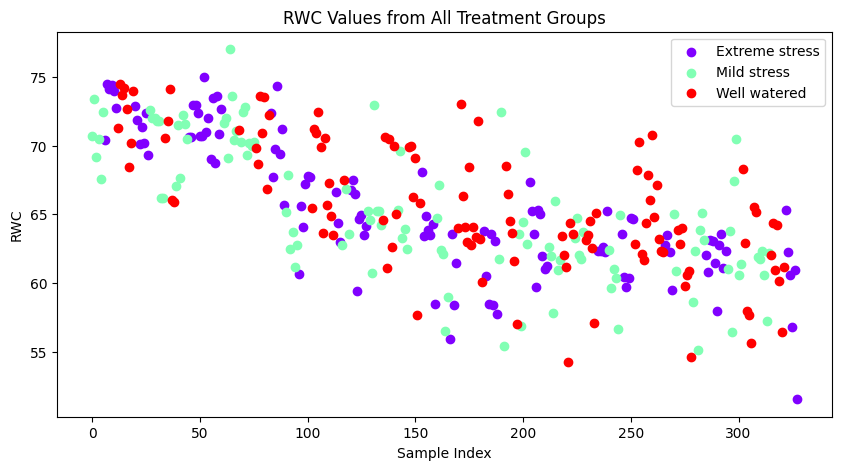

In [2]:
file_path = 'dataset\Hyperspectral\Combind_H_canopy.xlsx'  # Update with your file path
df = pd.read_excel(file_path)

# Group by Treatment
grouped = df.groupby('Treatment')

# Plot RWC values from all treatment groups with different colors
plt.figure(figsize=(10, 5))
colors = plt.cm.rainbow(np.linspace(0, 1, len(grouped)))

for (treatment, group), color in zip(grouped, colors):
    plt.scatter(group.index, group['RWC'], label=treatment, color=color)

plt.xlabel('Sample Index')
plt.ylabel('RWC')
plt.title('RWC Values from All Treatment Groups')
plt.legend()
plt.show()

In [3]:
#import data
dataset='dataset\Hyperspectral\Combind_H_canopy.xlsx'
analysis = SpectralAnalysis(dataset,'PLSR')
analysis.preprocess_data()
def rwctocat(clss):
    if clss== 'Well watered':
        return 0
    elif clss== 'Mild stress':
        return 1
    else:
        return 2

X_train, y_train_reg, y_train_class, X_test, y_test_reg, y_test_class = analysis.X_train, analysis.y_train_reg.iloc[:,0],analysis.y_train_class,analysis.X_test,analysis.y_test_reg.iloc[:,0],analysis.y_test_class

y_train_class = y_train_class.astype('category').cat.codes.to_numpy()
y_test_class =  y_test_class.astype('category').cat.codes.to_numpy()
print(f'Training sample {X_train.shape[0]}')
print(f'Total spectra {X_train.shape[1]}')
print(f'Val sample {X_test.shape[0]}')

Training sample 262
Total spectra 130
Val sample 66


In [5]:
#version_1
class SpectralPatchEmbedding(nn.Module):
    """
    Embeds spectral data into patches with a specified embedding dimension.
    
    Parameters:
        patch_size (int): The size of each patch.
        embedding_dim (int): The dimensionality of the embedding output.
    """
    def __init__(self, patch_size: int, embedding_dim :int)-> None:
        super().__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size, embedding_dim)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # print(f'here {x.shape}')
        x = x.unfold(1, self.patch_size, self.patch_size)
        # print(f'after unfold {x.shape}')
        x = x.view(x.size(0), -1, self.patch_size)

        # print(f'after view {x.shape}')
        x = self.embedding(x)
        return x

class PositionalEncoding(nn.Module):
    """
    Adds a positional encoding to embedded spectral data.
    
    Parameters:
        d_model (int): The dimensionality of the model's input.
        max_len (int, optional): The maximum length of the input sequences. Defaults to 5000.
        base (float, optional): The base of the logarithm used in calculating the div_term. Defaults to 10000.0.
    """
    def __init__(self, d_model: int, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

class FeatureExtractor(nn.Module):
    '''
    FeatureExtractor: Extracts features from spectral data using a Transformer encoder.
    '''
    def __init__(self, num_features : int , patch_size : int , embedding_dim : int, num_heads : int, num_encoder_layers : int, 
                 dim_feedforward : int,activation_fn=F.relu)-> None:
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.patch_embedding = SpectralPatchEmbedding(patch_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, activation=activation_fn,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        batch_size = inputs.size(0)
        #print(f'inputs= {inputs.shape}')
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        inputs = self.patch_embedding(inputs) #[batch_size,patches,embedding]
        # print(f'after patch_embedding= {inputs.shape}')
        inputs = torch.cat((cls_tokens, inputs), dim=1) #[batch_size,patches+ cls token,embedding]
        #print(f'after class token= {inputs.shape}')
        inputs = self.pos_encoder(inputs)
        output = self.transformer_encoder(inputs) #[batch_size,patches+ cls token,embedding]
        #print(f'after transformer= {output.shape}')
        return output

class ClassificationHead(nn.Module):
    '''
    ClassificationHead: Performs classification on features extracted from spectral data.
    Incorporates AdaptiveAvgPool1d for pooling over sequence dimension.
    '''
    def __init__(self, input_features : int, hidden_features: int,embedding_dim: int, num_classes: int
                 ,activation_fn=F.relu)-> None:
        super(ClassificationHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_classes)
        # Initialize AdaptiveAvgPool1d
        # Here, output size is set to 1 to pool across all sequence elements
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(embedding_dim//2))
        self.activation=activation_fn

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        

        #print(f'in classification {inputs.shape}')
        
        # Apply adaptive pooling to reduce seq_len to 1
        x = self.adaptive_pool(inputs) 
        #print(f'in classification after pool {x.shape}')
        # Flatten the output for the linear layer
        x = torch.flatten(x, 1)  # Now x should be [batch_size, features= embedding//2 * patches * cls token]
        # Continue through the classification head
        #print(f'in classification after flat {x.shape}')
        x = self.activation(self.bn1(self.fc1(x)))
       
        x = self.dropout(x)
        x=self.activation(self.bn1(self.fc2(x)))
        x = self.fc3(x)
        # print(x.shape)
        #print(f'in classification after after flat {x.shape}')
        # Apply softmax to the output layer for classification probabilities
        return F.softmax(x, dim=1) 


class RegressionHead(nn.Module):
    '''
    RegressionHead: Performs regression on features extracted from spectral data.
    '''
    def __init__(self, input_features : int, hidden_features: int,embedding_dim: int, output_features: int,
                 activation_fn=F.relu)-> None:
        super(RegressionHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, output_features)
        self.dropout2 = nn.Dropout(0.5)
        self.activation=activation_fn
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(embedding_dim//2))

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        #print(f'inputs 1 shape in regression {inputs.shape}')
        x = self.adaptive_pool(inputs) # Assuming global average pooling over sequence dimension
        x = torch.flatten(x, 1)
        #print(f'x shape in regression {x.shape}')
        
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x= self.activation(self.bn1(self.fc2(x)))
        x = self.dropout2(x)
        #print(f'after regression= {x.shape}')
        x=self.fc3(x)
        return x

class CombinedModel(nn.Module):
    '''
    CombinedModel: Integrates FeatureExtractor, ClassificationHead, and RegressionHead.
    Allows optional bypass of ClassificationHead based on a flag.
    '''
    def __init__(self, num_features : int, patch_size : int, embedding_dim : int,
                 num_heads : int, num_encoder_layers : int, dim_feedforward : int,
                 hidden_features_class: int, num_classes: int, hidden_features_reg: int, output_features_reg: int,
                 use_classification : bool=True,activation_fn=F.relu)-> None:
        
        super().__init__()
        self.classification_input=((num_features//patch_size)+1)*(embedding_dim//2) #calculating classification inputs. +1 is the class token and //2 is for adaptive pooling factor
        if use_classification:
            regression_input= ((num_features//patch_size)+2)*(embedding_dim//2)
        else:
            regression_input= ((num_features//patch_size)+1)*(embedding_dim//2)
            
        self.feature_extractor = FeatureExtractor(num_features, patch_size, embedding_dim, num_heads, num_encoder_layers, dim_feedforward,activation_fn=F.gelu)
        self.use_classification = use_classification
        self.classification_head = ClassificationHead(self.classification_input, hidden_features_class,embedding_dim, num_classes,activation_fn=F.gelu)
        self.regression_head = RegressionHead(regression_input,hidden_features_reg,embedding_dim, 
                                              output_features_reg,activation_fn=F.relu)
        self.adjust_class_score=nn.Linear(num_classes,embedding_dim)
        
    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(inputs)
        
        if self.use_classification:
            class_scores = self.classification_head(features)
            #print(features.shape,class_scores.shape)
            class_scores_updated=self.adjust_class_score(class_scores)
            #print(features.shape,class_scores_updated.unsqueeze(1).shape)
            reg_input=torch.cat((features, class_scores_updated.unsqueeze(1)), dim=1) 
            #reg_input = features * class_scores_updated.unsqueeze(1)
            #print(f'regression features {reg_input.shape}')
            reg_output = self.regression_head(reg_input)
            return class_scores, reg_output
        else:
            reg_input=features
            reg_output = self.regression_head(reg_input)
            return None,reg_output


In [14]:
#version_2

class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, token_bias: bool) -> None:
        super().__init__()
        # assert d_numerical % patch_size == 0, "d_numerical must be divisible by patch_size"
        self.patch_size = patch_size
        self.weight = nn.Parameter(torch.Tensor(d_numerical // patch_size + 1, patch_size, embedding_dim))  # +1 for [CLS] token
        self.bias = nn.Parameter(torch.Tensor(d_numerical // patch_size + 1, embedding_dim)) if token_bias else None

        # Initialization inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: torch.Tensor) -> torch.Tensor:
        # Divide the numerical data into patches
        x_num = x_num.unfold(1, self.patch_size, self.patch_size)
        # Add [CLS] token
        cls_token = torch.ones(x_num.size(0), 1, self.patch_size, device=x_num.device)
        x_num = torch.cat([cls_token, x_num], dim=1)
        # Apply the embedding using the weight and bias tensors
        x = torch.einsum('bpn,pnd->bpd', x_num, self.weight)
        if self.bias is not None:
            x = x + self.bias[None, :, :]
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

class FeatureExtractor(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, device: str, attentionHeads: int, dim_feedforward: int,
                 num_encoder_layers: int, token_bias: bool, activation_fn=F.gelu) -> None:
        super(FeatureExtractor, self).__init__()
        self.spectralEmbedding = Tokenizer(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim, token_bias=token_bias)
        self.positionalEncoding = PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=attentionHeads, dim_feedforward=dim_feedforward,
                                                   activation=activation_fn, device=device, batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
    def forward(self, x: torch.Tensor):
        x = self.spectralEmbedding(x)
        # x = self.positionalEncoding(x)
        x = self.transformerEncoder(x)
        return x

class ClassificationHead(nn.Module):
    def __init__(self, input_features: int, classHeadfeatures: int, num_classes: int, activation_fn=F.relu) -> None:
        super(ClassificationHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, classHeadfeatures)
        self.bn1 = nn.BatchNorm1d(classHeadfeatures)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(classHeadfeatures, 32) 
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(16, num_classes)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(32//2))
        self.activation = activation_fn

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = inputs.squeeze(dim=1)
        x = self.activation(self.dropout1(self.bn1(self.fc1(x))))
        x = self.activation(self.dropout2(self.bn2(self.fc2(x))))
        x=self.adaptive_pool(x.unsqueeze(1)).squeeze(1)
        x = self.dropout3(self.fc3(x))
        return F.softmax(x, dim=1)

class RegressionHead(nn.Module):
    '''
    RegressionHead: Performs regression on features extracted from spectral data.
    '''
    def __init__(self, input_features: int, regHeadfeatures: int, output_features: int, activation_fn=F.relu) -> None:
        super(RegressionHead, self).__init__()
        #
        self.fc1 = nn.Linear(input_features, regHeadfeatures)
        self.bn1 = nn.BatchNorm1d(regHeadfeatures)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(regHeadfeatures, regHeadfeatures // 2)
        self.bn2 = nn.BatchNorm1d(regHeadfeatures // 2)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(regHeadfeatures // 2, regHeadfeatures // 4)
        self.bn3 = nn.BatchNorm1d(regHeadfeatures // 4)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(regHeadfeatures // 4, output_features)
        
        self.activation = activation_fn

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        # print('I am in regression')
        x = self.activation(self.bn1(self.fc1(inputs)))
        x = self.dropout1(x)
        
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        
        return x


class CombinedModel(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, device: str, attentionHeads: int, dim_feedforward: int,
                 num_encoder_layers: int, token_bias: bool, classHeadfeatures: int, 
                 useClassification: bool, num_classes: int, regression_output:int, 
                 regressionHeadFetures:int, activation_fn=F.gelu) -> None:
        super(CombinedModel, self).__init__()
        self.useClassification = useClassification

        if self.useClassification:
            self.classificationHead = ClassificationHead(input_features=embedding_dim, classHeadfeatures=classHeadfeatures, 
                                                        num_classes=num_classes, activation_fn=F.relu)
            regression_input_dim = (d_numerical//patch_size) * embedding_dim + num_classes 
            # print(regression_input_dim)
        else:
            regression_input_dim = (d_numerical//patch_size) * embedding_dim
            # print(regression_input_dim)
        self.featureExtractor = FeatureExtractor(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim,
                                                 device=device, attentionHeads=attentionHeads, dim_feedforward=dim_feedforward,
                                                 num_encoder_layers=num_encoder_layers, token_bias=token_bias)
        

        

        self.RegressionHead =  RegressionHead(input_features= regression_input_dim, regHeadfeatures=regressionHeadFetures,
                                            output_features=regression_output, activation_fn=F.relu)


    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.featureExtractor(inputs)
        if self.useClassification:
            class_score = self.classificationHead(x[:, 0, :])
            regression_input = x[:, 1:, :].reshape(x.size(0), -1)  # Use all except the first patch
            regression_input = torch.cat((regression_input, class_score), dim=1)
            # print(f'regressionInput {regression_input.shape}')
            regression_output = self.RegressionHead(regression_input)
            return class_score, regression_output
        else:
            regression_input = x[:, 1:, :].reshape(x.size(0), -1)  # Use all except the first patch
            # print(f" \n regression_input {regression_input.shape} \n")
            regression_output = self.RegressionHead(regression_input)
            return regression_output

# dummy_input = torch.randn(1, 177).to(device)
# model = CombinedModel(d_numerical=177, patch_size=42, embedding_dim=36, device = device, attentionHeads = 6, dim_feedforward = 32,
#                       num_encoder_layers = 4, token_bias = True, classHeadfeatures = 64, useClassification = True, 
#                       num_classes = 3, regression_output = 1, regressionHeadFetures = 256, activation_fn = F.gelu)

# summary(model, input_size=(1, 177))


In [6]:
class MultiTaskLossWrapper(nn.Module):
    """
    MultiTaskLossWrapper calculate the weighted loss based on classification scores and regression scores. 
    Weights are learnable able parameters. 
    """
    def __init__(self, model,train_flag=True)-> None:
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()
        # Initialize learnable weights for each loss component
        self.task_weights = nn.Parameter(torch.ones(2, dtype=torch.float))
        self.flag=train_flag

    def forward(self, inputs, targets_classification, targets_regression):
        self.model.train(self.flag)
        class_scores, reg_output = self.model(inputs)
       
    
        loss_classification = self.classification_loss(class_scores, targets_classification)

        loss_regression = self.regression_loss(reg_output.view(-1), targets_regression.view(-1))
        # Combine losses with learnable weights
        #apply softmax to task_weights to ensure they are non-negative and sum to 1
#         weights = F.softmax(self.task_weights, dim=0)
        
#         combined_loss = torch.sum(weights[0] * loss_classification +
#                                   weights[1] * loss_regression)
        combined_loss=torch.sum(torch.sqrt(loss_classification) + loss_regression)
#         print(f'first weight {weights[0]} \n 2nd weight {weights[1]}')
        return combined_loss, loss_classification, loss_regression
# class MultiTaskLossWrapper(nn.Module):
#     """
#     MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
#     using homoscedastic uncertainty as learnable parameters to weight the losses.
#     """
#     def __init__(self, model, train_flag=True):
#         super(MultiTaskLossWrapper, self).__init__()
#         self.model = model
#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()
#         # Initialize log variance (uncertainty) parameters for each task with uniform distribution
#         #self.log_sigma1 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For classification
#         #self.log_sigma2 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For regression

#         self.log_sigma = nn.Parameter(torch.ones(2, dtype=torch.float))
        
#         self.train_flag = train_flag

#     def forward(self, inputs, targets_classification, targets_regression):
#         self.model.train(self.train_flag)
#         class_scores, reg_output = self.model(inputs)
        
#         # Compute classification and regression losses
#         loss = [self.classification_loss(class_scores, targets_classification),
#                 self.regression_loss(reg_output, targets_regression)]
#         loss_sum = 0
#         for i, l in enumerate(loss):
#             loss_sum += (0.5 / (self.log_sigma[i] ** 2)) * l + torch.log(1 + self.log_sigma[i] ** 2)
#         #print(f'Classification Loss Weight: {self.log_sigma[0]}, Regression Loss Weight: {self.log_sigma[1]}')
#         return loss_sum,(0.5 / (self.log_sigma** 2)),loss

In [8]:
#### version_1
num_features = X_train.shape[1]  # Number of features in each sample
patch_size = 8 # Arbitrary choice for the sake of example
embedding_dim = 128 # Embedding dimension after patch embedding
num_heads = 4 # Number of attention heads in Transformer encoder
num_encoder_layers = 4 # Number of layers in Transformer encoder
dim_feedforward = 512 # Dimension of feedforward network in Transformer encoder
hidden_features_class = 64  # Hidden layer size for  (num_features//patch_size + cls token) * (embedding_dim got half due to adp )
num_classes = 3  # Number of classes for classification
hidden_features_reg = 128  # Hidden layer size for regression head
output_features_reg = 1  # Output size for regression (single value prediction)
use_classification = True # Flag to use classification head
batch_size=32
# Initialize the combined model
combined_model = CombinedModel(num_features, patch_size, embedding_dim, num_heads, num_encoder_layers,
                               dim_feedforward, hidden_features_class, num_classes, hidden_features_reg,
                               output_features_reg, use_classification)
combined_model.to(device)
loss_wrapper= MultiTaskLossWrapper(combined_model)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001, weight_decay= 1e-5)  # Default weight decay for all parameters not explicitly set



# Create a TensorDataset
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_class).long(), torch.from_numpy(y_train_reg.values).float())
#train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_reg.values).float())

val_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_class).long(), torch.from_numpy(y_test_reg.values).float())

#val_dataset = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test_reg.values).float())

# Create a DataLoader
training_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)


validation_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=2)
writer = SummaryWriter('runs/actual3')
summary(combined_model,input_size=(1,177))

C:\Users\mzr0134\AppData\Local\Temp\ipykernel_9264\3449656337.py:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_class).long(), torch.from_numpy(y_train_reg.values).float())
c:\blue_berry\python_pipeline\scripts\env\Lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(


Layer (type:depth-idx)                             Output Shape              Param #
CombinedModel                                      [1, 3]                    --
├─FeatureExtractor: 1-1                            [1, 23, 128]              128
│    └─SpectralPatchEmbedding: 2-1                 [1, 22, 128]              --
│    │    └─Linear: 3-1                            [1, 22, 128]              1,152
│    └─PositionalEncoding: 2-2                     [1, 23, 128]              --
│    └─TransformerEncoder: 2-3                     [1, 23, 128]              --
│    │    └─ModuleList: 3-2                        --                        793,088
├─ClassificationHead: 1-2                          [1, 3]                    --
│    └─AdaptiveAvgPool1d: 2-4                      [1, 23, 64]               --
│    └─Linear: 2-5                                 [1, 64]                   94,272
│    └─BatchNorm1d: 2-6                            [1, 64]                   128
│    └─Dropout: 2-7  

In [18]:
# v2
d_numerical=177,
patch_size=32, 
embedding_dim=16,  
attentionHeads = 4,
dim_feedforward = 512,
num_encoder_layers =6, 
token_bias = True, 
classHeadfeatures = 512, 
useClassification = True, 
num_classes = 3, 
regression_output = 1, 
regressionHeadFetures =512, 
activation_fn = F.relu
batch_size=20
modelv2 = CombinedModel(d_numerical=180, patch_size=16,
                        embedding_dim=64, device = device, 
                        attentionHeads = 4, dim_feedforward = 256,
                        num_encoder_layers = 6, token_bias = True, 
                        classHeadfeatures = 512, useClassification = True, 
                        num_classes = 3, regression_output = 1, 
                        regressionHeadFetures = 256, activation_fn = F.relu)
modelv2.to(device)
loss_wrapper= MultiTaskLossWrapper(modelv2)

optimizer = optimizer = optim.Adam(modelv2.parameters(), lr=0.001, weight_decay= 1e-5)  # Default weight decay for all parameters not explicitly set
  # Default weight decay for all parameters not explicitly set



# Create a TensorDataset
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_class).long(), torch.from_numpy(y_train_reg.values).float())
#train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_reg.values).float())

val_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_class).long(), torch.from_numpy(y_test_reg.values).float())

#val_dataset = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test_reg.values).float())

# Create a DataLoader
training_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)


validation_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=2)
writer = SummaryWriter('runs/actual3')
summary(modelv2,input_size=(1,180))

Layer (type:depth-idx)                             Output Shape              Param #
CombinedModel                                      [1, 3]                    --
├─FeatureExtractor: 1-1                            [1, 12, 64]               --
│    └─Tokenizer: 2-1                              [1, 12, 64]               13,056
│    └─TransformerEncoder: 2-2                     [1, 12, 64]               --
│    │    └─ModuleList: 3-1                        --                        299,904
├─ClassificationHead: 1-2                          [1, 3]                    --
│    └─Linear: 2-3                                 [1, 512]                  33,280
│    └─BatchNorm1d: 2-4                            [1, 512]                  1,024
│    └─Dropout: 2-5                                [1, 512]                  --
│    └─Linear: 2-6                                 [1, 32]                   16,416
│    └─BatchNorm1d: 2-7                            [1, 32]                   64
│    └─Dropout:

<Axes: >

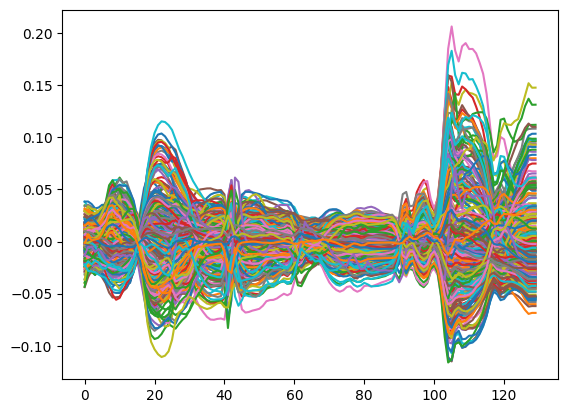

In [4]:
train_df=pd.DataFrame(X_train)
train_df.iloc[:,:].T.plot(legend=False)

c:\blue_berry\python_pipeline\scripts\env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0 ---- train loss: 0.0010744253396987916 --- val loss: 0.5954839885234833
Epoch 1 ---- train loss: 0.0009402580857276917 --- val loss: 0.5955091491341591
Epoch 2 ---- train loss: 0.000979632616043091 --- val loss: 0.6198775470256805
Epoch 3 ---- train loss: 0.0008970823287963867 --- val loss: 0.625514954328537
Epoch 4 ---- train loss: 0.0006856444478034973 --- val loss: 0.5841241031885147
Epoch 5 ---- train loss: 0.0008559443354606628 --- val loss: 0.5335809588432312
Epoch 6 ---- train loss: 0.0007932599782943725 --- val loss: 0.5771121978759766
Epoch 7 ---- train loss: 0.0009059431552886963 --- val loss: 0.6236698478460312
Epoch 8 ---- train loss: 0.0008492680191993713 --- val loss: 0.6398562490940094
Epoch 9 ---- train loss: 0.0007756379246711731 --- val loss: 0.5924220234155655
Epoch 10 ---- train loss: 0.000816513478755951 --- val loss: 0.588203027844429
Epoch 11 ---- train loss: 0.0009057472348213195 --- val loss: 0.5713151693344116
Epoch 12 ---- train loss: 0.00089900004863

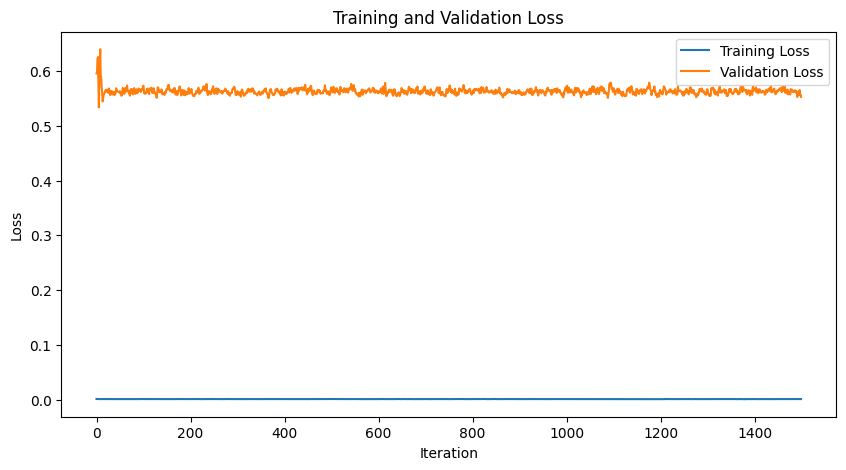

In [15]:
############
#  MLP model
class SpectralMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_prob, device):
        super(SpectralMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.bn1 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.bn2 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim//2).to(device)
        self.bn3 = nn.BatchNorm1d(hidden_dim//2).to(device)
        self.fc4 = nn.Linear(hidden_dim//2, hidden_dim//2).to(device)
        self.bn4 = nn.BatchNorm1d(hidden_dim//2).to(device)
        self.fc5 = nn.Linear(hidden_dim//2, hidden_dim//4).to(device)
        self.bn5 = nn.BatchNorm1d(hidden_dim//4).to(device)
        self.fc6 = nn.Linear(hidden_dim//4, hidden_dim//4).to(device)
        self.bn6 = nn.BatchNorm1d(hidden_dim//4).to(device)
        self.output = nn.Linear(hidden_dim//4, output_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 1
learning_rate = 0.0256
num_epochs = 100
dropout_prob = 0.4
weight_decay = 0.005
# Initialize the model, loss function, and optimizer
mlp = SpectralMLP(input_dim, output_dim, hidden_dim,dropout_prob,device=device)
criterion = nn.MSELoss()  # RMSE can be obtained by taking the square root of MSE
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

# Dummy data (replace with your actual data)
# Assuming you have X as input spectral data of shape (num_samples, 180)
# and y as RWC values of shape (num_samples, 1)

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_class).long(), torch.from_numpy(y_train_reg.values).float())
#train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_reg.values).float())

val_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_class).long(), torch.from_numpy(y_test_reg.values).float())

#val_dataset = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test_reg.values).float())
batch_size=64
# Create a DataLoader
training_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)


validation_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=1)
# Training loop
train_loss = []
val_loss = []

for epoch in range(1500):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        x_batch, _, y_reg_batch = data
        optimizer.zero_grad()
        logits = mlp(x_batch.to(device=device))
        
        loss=torch.sqrt(criterion(logits.to(device=device).view(-1),y_reg_batch.to(device=device).view(-1)))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 10 == 0:  # Every 10 mini-batches...
            # Check against the validation set
            running_vloss = 0.0
            mlp.eval()  # Put the model in evaluation mode
            with torch.no_grad():  # Don't need to track gradients for validation
                for j, vdata in enumerate(validation_loader, 0):
                    vx_batch, _, vy_reg_batch = vdata
                    vlogits = mlp(vx_batch.to(device=device))
                    vloss=torch.sqrt(criterion(vlogits.to(device=device).view(-1),vy_reg_batch.to(device=device).view(-1)))
                    running_vloss += vloss.item()
            
            mlp.train()  # Put the model back in training mode
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # Append the average loss to the lists
            train_loss.append(avg_loss)
            val_loss.append(avg_vloss)

            # Log the running loss averaged per batch
            # writer.add_scalars('Training vs. Validation Loss',
            #                    {'Training': avg_loss, 'Validation': avg_vloss},
            #                    epoch * len(train_loader) + i)

            running_loss = 0.0
            scheduler.step(avg_vloss)
    print(f'Epoch {epoch} ---- train loss: {avg_loss} --- val loss: {avg_vloss}')

print('Finished Training')

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
# writer.flush()

    

In [23]:
# grid searching
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score

class SpectralMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_prob, device):
        super(SpectralMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.bn1 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.bn2 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim//2).to(device)
        self.bn3 = nn.BatchNorm1d(hidden_dim//2).to(device)
        self.fc4 = nn.Linear(hidden_dim//2, hidden_dim//2).to(device)
        self.bn4 = nn.BatchNorm1d(hidden_dim//2).to(device)
        self.fc5 = nn.Linear(hidden_dim//2, hidden_dim//4).to(device)
        self.bn5 = nn.BatchNorm1d(hidden_dim//4).to(device)
        self.fc6 = nn.Linear(hidden_dim//4, hidden_dim//4).to(device)
        self.bn6 = nn.BatchNorm1d(hidden_dim//4).to(device)
        self.output = nn.Linear(hidden_dim//4, output_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Define the custom PyTorch model wrapper
class SpectralMLPWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=256, dropout_prob=0.4, learning_rate=0.0256, weight_decay=0.005, num_epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SpectralMLP(input_dim, 1, hidden_dim, dropout_prob, device=self.device).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=4, verbose=False)

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y if isinstance(y, np.ndarray) else y.values, dtype=torch.float32).view(-1, 1).to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for x_batch, y_batch in loader:
                self.optimizer.zero_grad()
                logits = self.model(x_batch)
                loss = torch.sqrt(self.criterion(logits, y_batch))
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(loader)
            self.scheduler.step(avg_loss)
            print(f'Epoch {epoch+1}/{self.num_epochs}, Loss: {avg_loss:.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy().flatten()
        return predictions

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_dim': [32,100,120,128, 256,512],
    'dropout_prob': [0.1,0.15,0.2,0.25,0.3,0.35,0.4],
    'learning_rate': [0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.005,0.007,0.01],
    'weight_decay': [0.00005,0.00006,0.00007,0.00008,0.00009,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.007,0.0008,0.0009],
    'num_epochs': [50, 100]
}

# Create the GridSearchCV object
scorer = make_scorer(r2_score)
grid_search = GridSearchCV(estimator=SpectralMLPWrapper(input_dim=X_train.shape[1]),
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train_reg)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_mlp = grid_search.best_estimator_

# Predict on test data
y_pred = best_mlp.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test_reg, y_pred)
print(f'R2 Score on test data: {r2}')

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
Epoch 1/50, Loss: 1.0200
Epoch 2/50, Loss: 0.8804
Epoch 3/50, Loss: 0.8356
Epoch 4/50, Loss: 0.9331
Epoch 5/50, Loss: 0.8827
Epoch 6/50, Loss: 0.8096
Epoch 7/50, Loss: 0.7347
Epoch 8/50, Loss: 0.7724
Epoch 9/50, Loss: 0.8193
Epoch 10/50, Loss: 0.7636
Epoch 11/50, Loss: 0.8023
Epoch 12/50, Loss: 0.7006
Epoch 13/50, Loss: 0.7867
Epoch 14/50, Loss: 0.7938
Epoch 15/50, Loss: 0.7295
Epoch 16/50, Loss: 0.7218
Epoch 17/50, Loss: 0.7775
Epoch 18/50, Loss: 0.8089
Epoch 19/50, Loss: 0.7652
Epoch 20/50, Loss: 0.7955
Epoch 21/50, Loss: 0.7610
Epoch 22/50, Loss: 0.7919
Epoch 23/50, Loss: 0.7463
Epoch 24/50, Loss: 0.7682
Epoch 25/50, Loss: 0.7430
Epoch 26/50, Loss: 0.7635
Epoch 27/50, Loss: 0.8077
Epoch 28/50, Loss: 0.7564
Epoch 29/50, Loss: 0.6380
Epoch 30/50, Loss: 0.7608
Epoch 31/50, Loss: 0.7298
Epoch 32/50, Loss: 0.7505
Epoch 33/50, Loss: 0.7476
Epoch 34/50, Loss: 0.7869
Epoch 35/50, Loss: 0.7282
Epoch 36/50, Loss: 0.8349
Epoch 37

In [30]:


# Define the MLP model
class SpectralMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_prob, device):
        super(SpectralMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.bn1 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.bn2 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2).to(device)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2).to(device)
        self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim // 2).to(device)
        self.bn4 = nn.BatchNorm1d(hidden_dim // 2).to(device)
        self.fc5 = nn.Linear(hidden_dim // 2, hidden_dim // 4).to(device)
        self.bn5 = nn.BatchNorm1d(hidden_dim // 4).to(device)
        self.fc6 = nn.Linear(hidden_dim // 4, hidden_dim // 4).to(device)
        self.bn6 = nn.BatchNorm1d(hidden_dim // 4).to(device)
        self.output = nn.Linear(hidden_dim // 4, output_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Define the custom PyTorch model wrapper
class SpectralMLPWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=256, dropout_prob=0.4, learning_rate=0.0256, weight_decay=0.005, num_epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SpectralMLP(input_dim, 1, hidden_dim, dropout_prob, device=self.device).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=4, verbose=False)
        self.train_loss = []
        self.val_loss = []

    def fit(self, X, y, X_val=None, y_val=None):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y if isinstance(y, np.ndarray) else y.values, dtype=torch.float32).view(-1, 1).to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(self.device)
            y_val_tensor = torch.tensor(y_val if isinstance(y_val, np.ndarray) else y_val.values, dtype=torch.float32).view(-1, 1).to(self.device)

        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for x_batch, y_batch in loader:
                self.optimizer.zero_grad()
                logits = self.model(x_batch)
                loss = torch.sqrt(self.criterion(logits, y_batch))
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(loader)
            self.train_loss.append(avg_loss)

            if X_val is not None and y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_logits = self.model(X_val_tensor)
                    val_loss = torch.sqrt(self.criterion(val_logits, y_val_tensor)).item()
                self.val_loss.append(val_loss)
                self.model.train()

            self.scheduler.step(avg_loss)
            print(f'Epoch {epoch+1}/{self.num_epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}' if X_val is not None and y_val is not None else f'Epoch {epoch+1}/{self.num_epochs}, Loss: {avg_loss:.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy().flatten()
        return predictions

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_dim': [32, 100, 120, 128, 256, 512],
    'dropout_prob': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    'learning_rate': [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.005, 0.007, 0.01],
    'weight_decay': [0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.007, 0.0008, 0.0009],
    'num_epochs': [50, 100]
}

# Create the GridSearchCV object
scorer = make_scorer(r2_score)
grid_search = GridSearchCV(estimator=SpectralMLPWrapper(input_dim=X_train.shape[1]),
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5,
                           verbose=2,
                           n_jobs=-1)



# Fit the model
grid_search.fit(X_train, y_train_reg, X_val=X_test, y_val=y_test_reg)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_mlp = grid_search.best_estimator_

# Predict on test data
y_pred = best_mlp.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R2 Score on test data: {r2}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(best_mlp.train_loss, label='Training Loss')
plt.plot(best_mlp.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


c:\blue_berry\python_pipeline\scripts\env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fitting 5 folds for each of 14112 candidates, totalling 70560 fits


In [11]:
train_loss = []
val_loss = []

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        x_batch, y_class_batch, y_reg_batch = data
        optimizer.zero_grad()
        combined_loss, loss_class, loss_reg = loss_wrapper(x_batch.to(device), y_class_batch.to(device), y_reg_batch.to(device))
        combined_loss.backward()
        optimizer.step()

        running_loss += loss_reg.item()
        
        if i % 10 == 0:  # Every 10 mini-batches...
            # Check against the validation set
            running_vloss = 0.0
            combined_model.eval()  # Put the model in evaluation mode
            with torch.no_grad():  # Don't need to track gradients for validation
                for j, vdata in enumerate(validation_loader, 0):
                    vx_batch, vy_class_batch, vy_reg_batch = vdata
                    vcombined_loss, vloss_class, vloss_reg = loss_wrapper(vx_batch.to(device), vy_class_batch.to(device), vy_reg_batch.to(device))
                    running_vloss += vloss_reg.item()
            
            combined_model.train()  # Put the model back in training mode
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # Append the average loss to the lists
            train_loss.append(avg_loss)
            val_loss.append(avg_vloss)

            # Log the running loss averaged per batch
            # writer.add_scalars('Training vs. Validation Loss',
            #                    {'Training': avg_loss, 'Validation': avg_vloss},
            #                    epoch * len(train_loader) + i)

            running_loss = 0.0

    print(f'Epoch {epoch} ---- train loss: {avg_loss} --- val loss: {avg_vloss}')

print('Finished Training')

# writer.flush()


NameError: name 'loss_wrapper' is not defined

In [ ]:
batch = next(iter(training_loader))
yhat = combined_model(batch[0]) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(combined_model.named_parameters())))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

tensor([[-0.0126, -0.0085, -0.0053,  ..., -0.0372, -0.0373, -0.0373],
        [-0.0146, -0.0155, -0.0162,  ...,  0.0967,  0.0968,  0.0968],
        [-0.0406, -0.0481, -0.0522,  ...,  0.1150,  0.1133,  0.1133],
        ...,
        [-0.1105, -0.1010, -0.0934,  ...,  0.0382,  0.0389,  0.0389],
        [-0.0139, -0.0139, -0.0140,  ..., -0.0222, -0.0222, -0.0222],
        [-0.0261, -0.0281, -0.0292,  ...,  0.0317,  0.0317,  0.0317]])


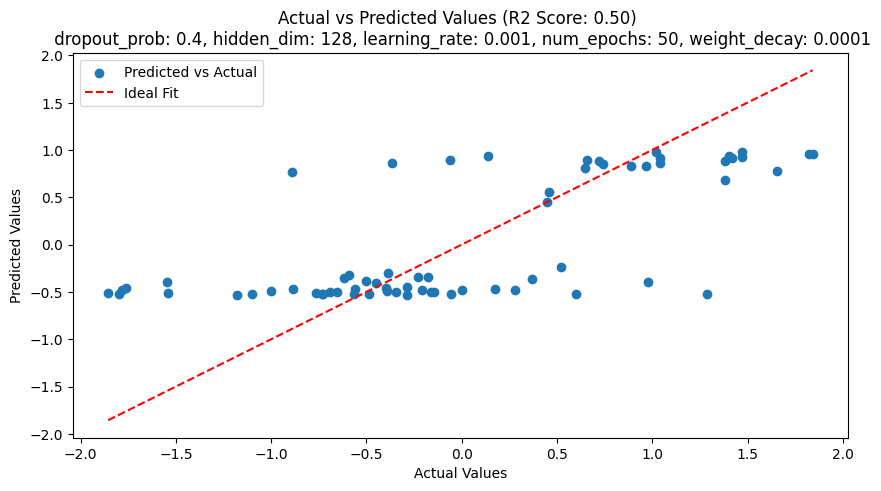

R2 Score: 0.50


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Switch model to evaluation mode
best_mlp.model.eval()

# Generate some test data
# test_features = torch.randn(20, 177).to(device)
# test_labels = torch.randint(0, 3, (20,)).to(device)
# test_regression_targets = torch.randn(20, 1).to(device)

# Make predictions
with torch.no_grad():
    print(torch.Tensor(X_train))
    reg_outputs = best_mlp.model(torch.Tensor(X_test).to(device=device))
    
# Convert tensors to numpy arrays for plotting
y_actual = y_test_reg
y_pred = reg_outputs.detach().cpu().numpy()

# Calculate R-squared value
r2 = r2_score(y_actual, y_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_actual, y_pred, label='Predicted vs Actual')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R2 Score: {r2:.2f}) \n dropout_prob: 0.4, hidden_dim: 128, learning_rate: 0.001, num_epochs: 50, weight_decay: 0.0001')
plt.legend()
plt.show()

print(f"R2 Score: {r2:.2f}")


In [21]:
print(np.argmax(class_scores.detach().cpu().numpy(),axis=1))
print(y_test_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[2 2 0 0 1 2 1 1 0 0 2 1 2 2 0 0 1 1 0 1 2 2 0 0 1 0 0 1 1 1 1 0 2 2 2 2 0
 1 1 0 0 1 1 2 0 2 0 1 0 2 2 1 0 2 2 0 0 2 1 1 0 0 0 0 2 2]


Inception try

In [ ]:
import os
os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz-11.0.0-win64\bin"

In [ ]:
from Inception_model import Inception
from utils import init_weights,Make_one_one_plot,benchmark,train_One_epoch,evaluate

In [ ]:
model=Inception()
model = model.apply(init_weights)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(),lr=0.00316) 

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0002633, max_lr=0.00316,step_size_up=3664, 
                                              step_size_down=None, mode='exp_range',gamma=0.99994,scale_fn=None,
                                              cycle_momentum=False)

In [ ]:
training_losses=[]
training_lrs=[]
validation_losses=[]
best_valid=1000
for epoch in range(100):
    training_loss,lrs=train_One_epoch(model,training_loader,optimizer,loss_fn)  
    training_losses.append(training_loss)
    training_lrs.append(lrs)
    #Evaluate the model
    validation_loss=evaluate(model,val_loader,loss_fn)
    validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")
    
    #Check the losses and save the model
    if validation_loss < best_valid:
        best_valid = validation_loss
        print("New Best model found")
#         torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss':training_loss,
#                 'val_loss':validation_loss
#                 },f"../Deep learning approach/Weights/test_wts.pt")
    


ValueError: too many values to unpack (expected 2)

In [135]:
class SpectralPatchEmbedding(nn.Module):
    def __init__(self, patch_size: int, embedding_dim: int, device: str) -> None:
        super(SpectralPatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size, embedding_dim, device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(f'SpectralPatchEmbedding input shape: {x.shape}')
        x = x.unfold(1, self.patch_size, self.patch_size).contiguous()
        print(f'After unfold: {x.shape}')
        x = x.view(x.size(0), -1, self.patch_size)
        print(f'After view: {x.shape}')
        x = self.embedding(x)
        print(f'After embedding: {x.shape}')
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model,device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(f'in positionencoding {x.shape}')
        x = x + self.pe[:x.size(1)]
        print(f'after positionencoding {x[0,0].shape}')
        return x









dummy_input = torch.randn(1,177).to(device)


class models(nn.Module):
    def __init__(self, patch_size: int, embedding_dim: int, device: str,num_heads: int, dim_feedforward: int,
                 num_encoder_layers: int, activation_fn=F.gelu) -> None:
        super(models,self).__init__()
        self.spectralEmbedding= SpectralPatchEmbedding(patch_size = patch_size, embedding_dim= embedding_dim, device=device)
        self.positionalEncoding= PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward,
                                                    activation=activation_fn, device=device,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, x: torch.tensor):
        x= self.spectralEmbedding(x)
        x= self.positionalEncoding(x)
        # x= x.permute(1,0,2)
        x= self.transformer_encoder(x)
        print(f'After Transformer: {x.shape}')
        return x
model= models(patch_size=64, embedding_dim= 128, device=device,num_heads=1, dim_feedforward=1,num_encoder_layers=1)
# x=nn.Linear(8,64,device="cuda")
# print(x(dummy_input))
# print(model(dummy_input))
summary(model, input_size=(1,177))

SpectralPatchEmbedding input shape: torch.Size([1, 177])
After unfold: torch.Size([1, 2, 64])
After view: torch.Size([1, 2, 64])
After embedding: torch.Size([1, 2, 128])
in positionencoding torch.Size([1, 2, 128])
after positionencoding torch.Size([128])
After Transformer: torch.Size([1, 2, 128])


Layer (type:depth-idx)                        Output Shape              Param #
models                                        [1, 2, 128]               --
├─SpectralPatchEmbedding: 1-1                 [1, 2, 128]               --
│    └─Linear: 2-1                            [1, 2, 128]               8,320
├─PositionalEncoding: 1-2                     [1, 2, 128]               --
├─TransformerEncoder: 1-3                     [1, 2, 128]               --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 2, 128]               66,945
Total params: 75,265
Trainable params: 75,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Total Size (MB): 0.05

In [136]:
dict(model.named_modules())

{'': models(
   (spectralEmbedding): SpectralPatchEmbedding(
     (embedding): Linear(in_features=64, out_features=128, bias=True)
   )
   (positionalEncoding): PositionalEncoding()
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0): TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=1, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=1, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
 ),
 'spectralEmbedding': SpectralPatchEmbedding(
   (embedding): Linear(in_features=64, out_fe

In [48]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for intermediate layers
# modelv2.featureExtractor.spectralEmbedding.register_forward_hook(get_activation('spectralEmbedding'))
# modelv2.featureExtractor.positionalEncoding.register_forward_hook(get_activation('positionalEncoding'))
# modelv2.featureExtractor.transformerEncoder.register_forward_hook(get_activation('featureExtractor'))
# modelv2.classificationHead.fc1.register_forward_hook(get_activation('classHeadfeatures_fc1'))
# modelv2.classificationHead.fc2.register_forward_hook(get_activation('classHeadfeatures_fc2'))
# modelv2.classificationHead.fc3.register_forward_hook(get_activation('classHeadfeatures_fc3'))
# modelv2.RegressionHead.fc1.register_forward_hook(get_activation('RegressionHead_fc1'))
# modelv2.RegressionHead.fc2.register_forward_hook(get_activation('RegressionHead_fc2'))
# modelv2.RegressionHead.fc3.register_forward_hook(get_activation('RegressionHead_fc3'))
# modelv2.RegressionHead.fc4.register_forward_hook(get_activation('RegressionHead_fc4'))
mlp.fc1.register_forward_hook(get_activation('fc1'))
mlp.fc2.register_forward_hook(get_activation('fc2'))
mlp.fc3.register_forward_hook(get_activation('fc3'))
# mlp.fc4.register_forward_hook(get_activation('fc4'))
# mlp.fc5.register_forward_hook(get_activation('fc5'))
# Forward pass with hooks
batch = next(iter(training_loader))
output = mlp(batch[0].to(device=device))

Layer: fc1, Shape: torch.Size([32, 64])


C:\Users\mzr0134\AppData\Local\Temp\ipykernel_9264\1276312506.py:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


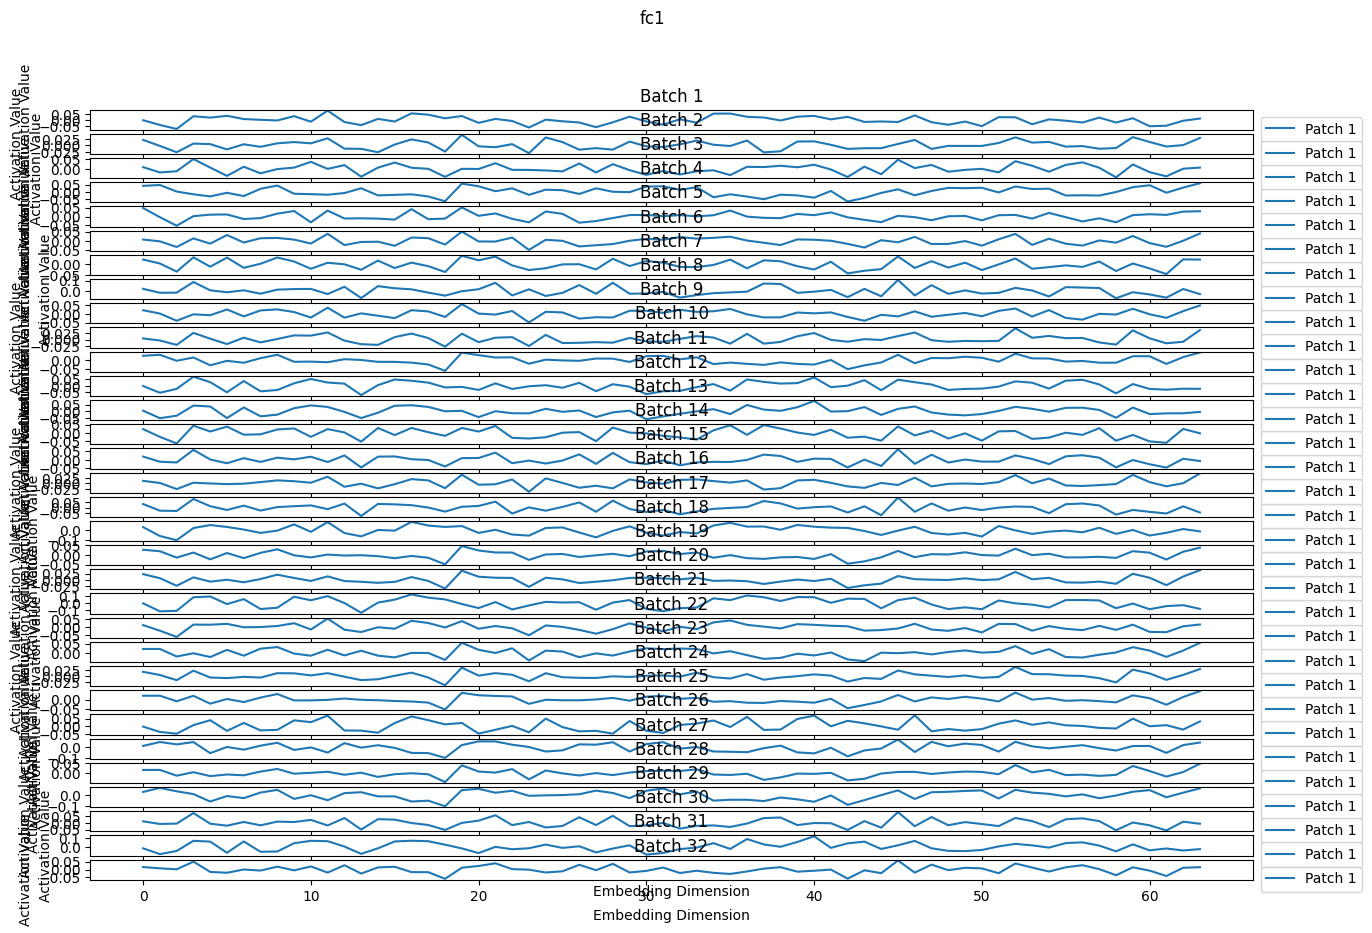

Layer: fc2, Shape: torch.Size([32, 32])


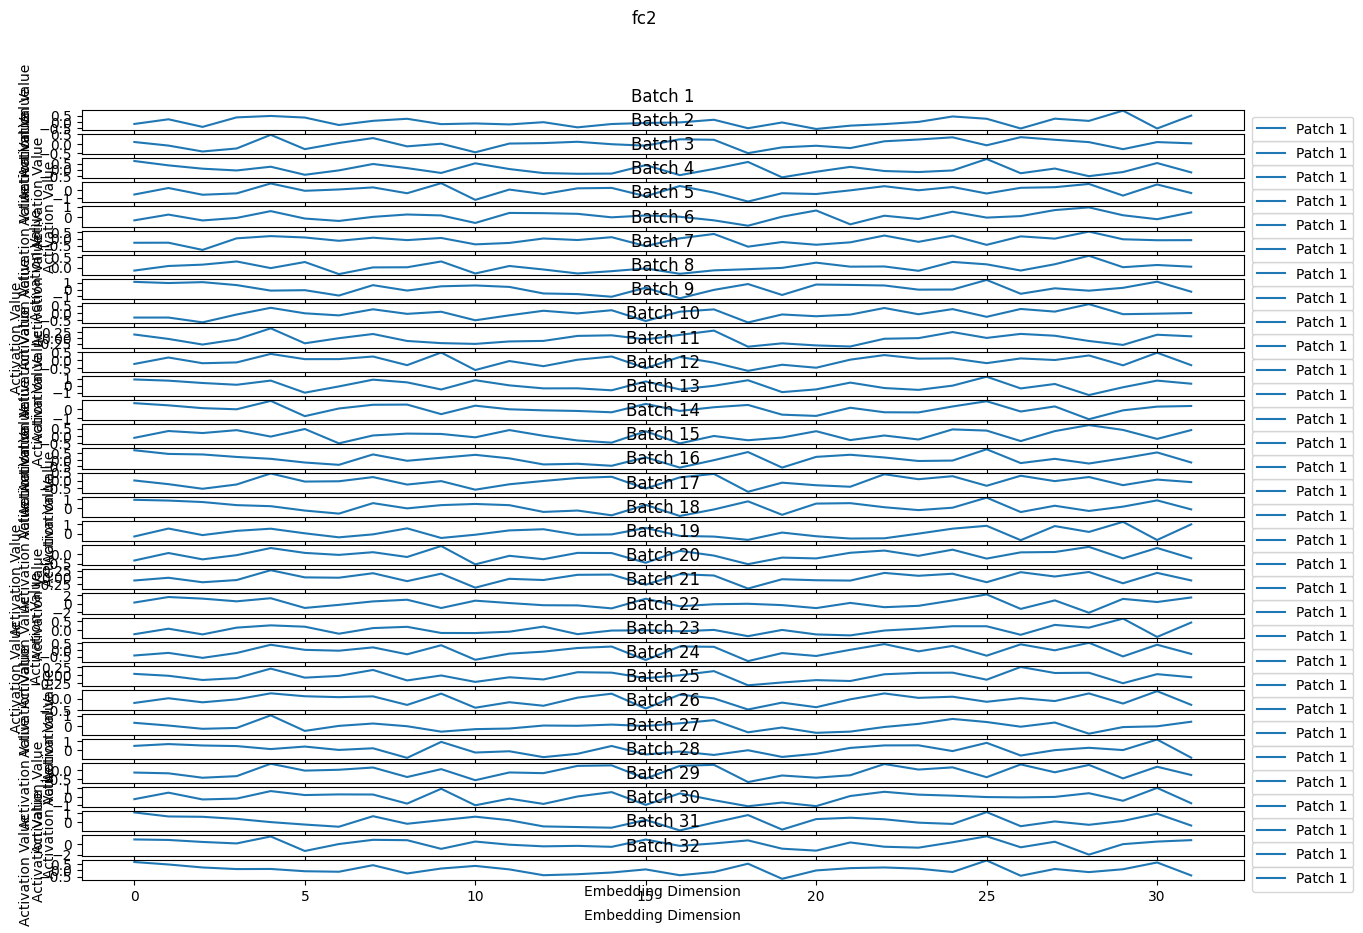

Layer: fc3, Shape: torch.Size([32, 16])


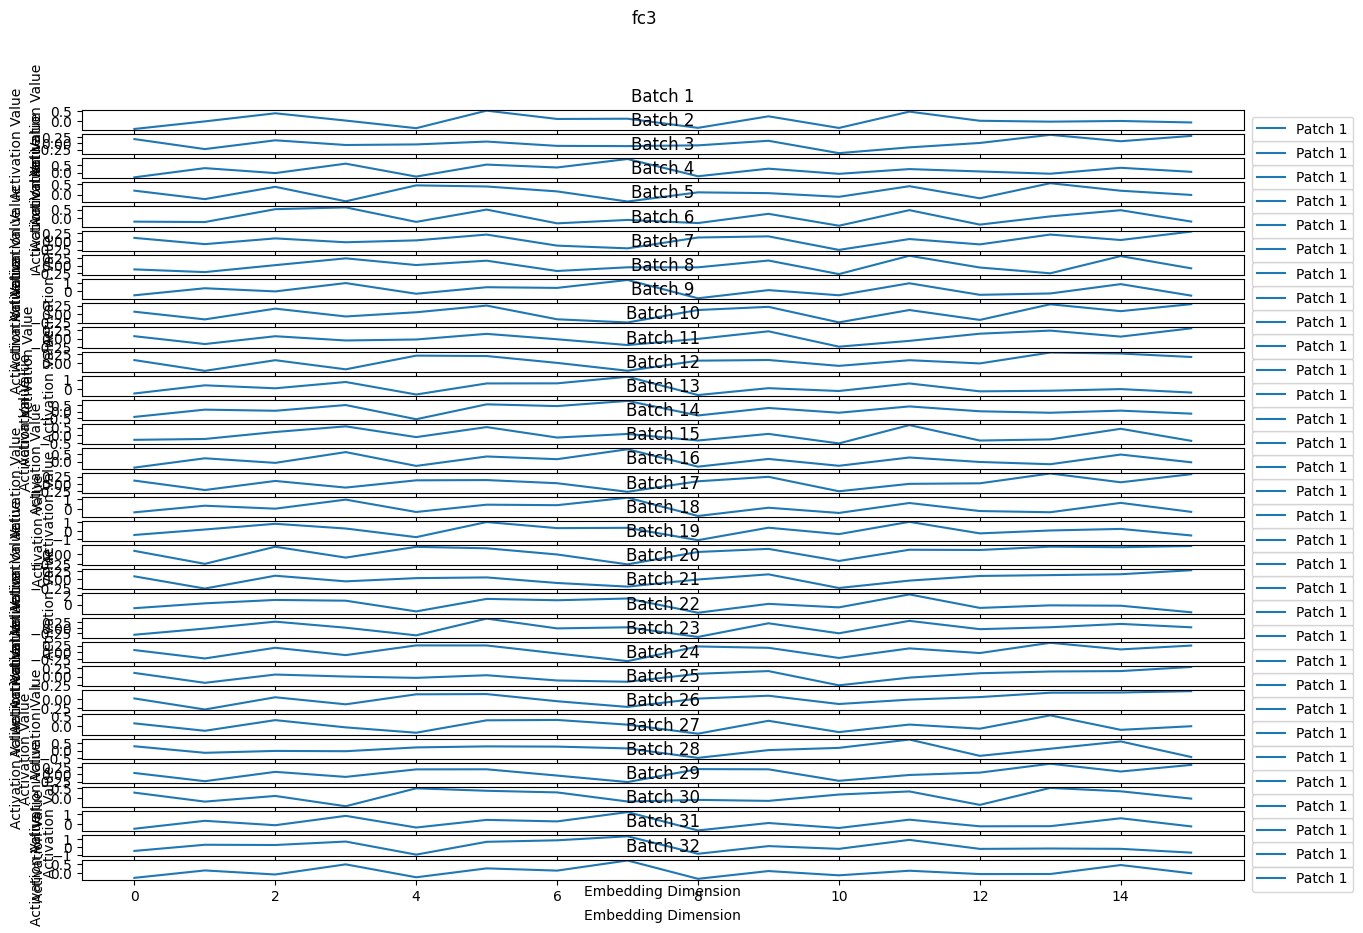

In [49]:

def hidden_layer_viz(activations):
    """
    This function will plot the activations of hidden layers.
    Input: activations --> {'layer_name': weights # batch x patch_size x embedding_dim}
    """
    for layer_name, activation in activations.items():
        print(f'Layer: {layer_name}, Shape: {activation.shape}')
    
        fig, axes = plt.subplots(activation.shape[0], 1, figsize=(15, 10))
        fig.suptitle(layer_name)

        if len(activation.squeeze().shape) == 2:  # If PATCH size is 1
            for i in range(activation.shape[0]):
                # Reshape the activation for each batch item to plot as line plots
                batch_activation = activation[i].cpu().numpy().squeeze()
                axes[i].plot(batch_activation, label='Patch 1')
                axes[i].set_title(f'Batch {i+1}')
                axes[i].set_xlabel('Embedding Dimension')
                axes[i].set_ylabel('Activation Value')
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        else:
            # For multiple patches
            for i in range(activation.shape[0]):
                # Reshape the activation for each batch item to plot as line plots
                batch_activation = activation[i].cpu().numpy()
                for j in range(activation.shape[1]):
                    axes[i].plot(batch_activation[j], label=f'Patch {j+1}')
                axes[i].set_title(f'Batch {i+1}')
                axes[i].set_xlabel('Embedding Dimension')
                axes[i].set_ylabel('Activation Value')
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
hidden_layer_viz(activations)

In [171]:
#with_patch
import torch
import torch.nn as nn
import torch.nn.init as nn_init
import typing as ty
from torch import Tensor
import math

class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int,token_bias: bool) -> None:
        super().__init__()
        assert d_numerical > patch_size
        self.patch_size = patch_size
        self.weight = nn.Parameter(Tensor(d_numerical // patch_size + 1, patch_size, embedding_dim))  # +1 for [CLS] token
        self.bias = nn.Parameter(Tensor(d_numerical // patch_size + 1, embedding_dim)) if bias else None

        # Initialization inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: Tensor) -> Tensor:
        # Divide the numerical data into patches
        print(f'before patch {x_num.shape}')
        x_num = x_num.unfold(1, self.patch_size, self.patch_size)
        print(f'after patch {x_num.shape}')
        # Add [CLS] token
        cls_token = torch.ones(x_num.size(0), 1, self.patch_size, device=x_num.device)
        print(f'cls_token {cls_token.shape}')
        x_num = torch.cat([cls_token, x_num], dim=1)
        print(f'after class {x_num.shape}')
        print(f'Weight {self.weight.shape}')
        # Apply the embedding using the weight and bias tensors
        x = torch.einsum('bpn,pnd->bpd', x_num, self.weight)  # Batch, Patches, Patch Size -> Batch, Patches, Token Dim
        print(f'self.bias {self.bias.shape}')
        print(f'x after {x.shape}')
        if self.bias is not None:
            x = x + self.bias[None]
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model,device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(f'in positionencoding {x.shape}')
        x = x + self.pe[:x.size(1)]
        print(f'after positionencoding {x[0,0].shape}')
        return x


dummy_input = torch.randn(1,177).to(device)


class models(nn.Module):
    def __init__(self,d_numerical: int, patch_size: int, embedding_dim: int, device: str,num_heads: int, dim_feedforward: int,
                 num_encoder_layers: int,token_bias:bool, activation_fn=F.gelu,) -> None:
        super(models,self).__init__()
        self.spectralEmbedding= Tokenizer(d_numerical=d_numerical, patch_size=patch_size,embedding_dim= embedding_dim, token_bias=token_bias)
        self.positionalEncoding= PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward,
                                                    activation=activation_fn, device=device,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, x: torch.tensor):
        x= self.spectralEmbedding(x)
        x= self.positionalEncoding(x)
        x= self.transformer_encoder(x)
        print(f'After Transformer: {x.shape}')
        return x
model= models(d_numerical=177,patch_size=8, embedding_dim= 128, device=device,num_heads=1, 
              dim_feedforward=1,num_encoder_layers=1,token_bias=True)
# x=nn.Linear(8,64,device="cuda")
# print(x(dummy_input))
# print(model(dummy_input))
summary(model, input_size=(1,177))


# # Sample usage:
# if __name__ == "__main__":
#     d_numerical = 177
#     patch_size = 8
#     d_token = 16
#     bias = True

#     tokenizer = Tokenizer(d_numerical, patch_size, d_token, bias)

#     # Example numerical data: batch of 2 samples, each with 20 features
#     x_num = torch.randn(2, d_numerical)
#     output = tokenizer(x_num)
#     print("Tokenizer output shape:", output.shape)
#     print(summary(tokenizer,input_size=(1,177)))

before patch torch.Size([1, 177])
after patch torch.Size([1, 22, 8])
cls_token torch.Size([1, 1, 8])
after class torch.Size([1, 23, 8])
Weight torch.Size([23, 8, 128])
self.bias torch.Size([23, 128])
x after torch.Size([1, 23, 128])
in positionencoding torch.Size([1, 23, 128])
after positionencoding torch.Size([128])
After Transformer: torch.Size([1, 23, 128])


Layer (type:depth-idx)                        Output Shape              Param #
models                                        [1, 23, 128]              --
├─Tokenizer: 1-1                              [1, 23, 128]              26,496
├─PositionalEncoding: 1-2                     [1, 23, 128]              --
├─TransformerEncoder: 1-3                     [1, 23, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 23, 128]              66,945
Total params: 93,441
Trainable params: 93,441
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.11
Estimated Total Size (MB): 0.20

In [140]:
#without_patch
import torch
import torch.nn as nn
import torch.nn.init as nn_init
import typing as ty
from torch import Tensor
import math

class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, d_token: int, bias: bool) -> None:
        super().__init__()
        self.weight = nn.Parameter(Tensor(d_numerical + 1, d_token))  # +1 for [CLS] token
        self.bias = nn.Parameter(Tensor(d_numerical + 1, d_token)) if bias else None

        # Initialization inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.zeros_(self.bias)

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: Tensor) -> Tensor:
        print(f'x_m {x_num.shape}')
        x_num = torch.cat(
            [torch.ones(len(x_num), 1, device=x_num.device)] + [x_num], dim=1
        )  # Add [CLS] token
        print(f'weight {self.weight.shape}')
        x = self.weight[None] * x_num[:, :, None]
        if self.bias is not None:
            x = x + self.bias[None]
        return x

# Sample usage:
if __name__ == "__main__":
    d_numerical = 177
    d_token = 16
    bias = True

    tokenizer = Tokenizer(d_numerical, d_token, bias)

    # Example numerical data: batch of 2 samples, each with 10 features
    x_num = torch.randn(2, d_numerical)
    output = tokenizer(x_num)
    print("Tokenizer output shape:", output.shape)
    print(summary(tokenizer,input_size=(1,177)))

x_m torch.Size([2, 177])
weight torch.Size([178, 16])
Tokenizer output shape: torch.Size([2, 178, 16])
x_m torch.Size([1, 177])
weight torch.Size([178, 16])
Layer (type:depth-idx)                   Output Shape              Param #
Tokenizer                                [1, 178, 16]              5,696
Total params: 5,696
Trainable params: 5,696
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
